<a href="https://colab.research.google.com/github/rmonro12/Intro_to_ML/blob/main/Homework_Assignments/HW_6/Problem_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ryan Monroe (801219572) - 11/18/2025 <br>
ECGR 4105 - Homework 6, Problem 1

In [ ]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

In [ ]:
# Import .csv dataset from class repository
url = 'https://raw.githubusercontent.com/HamedTabkhi/Intro-to-ML/refs/heads/main/Dataset/diabetes.csv'
df = pd.read_csv(url)
print(df.head()) # Confirm successful import by printing

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [ ]:
# Assign input and output variables
X = df.iloc[:, 0:8].values # input
Y = df.iloc[:, 8].values # output

# Convert to tensors for use with NN
X = torch.tensor(X)
Y = torch.tensor(Y)

In [ ]:
# Manipulate dataset
n_samples = X.shape[0]
n_val = int(0.2 * n_samples)
shuffled_indices = torch.randperm(n_samples)
train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

# Separate into training and validation
train_X_raw = X[train_indices].float()
train_Y_raw = Y[train_indices].float()
val_X_raw = X[val_indices].float()
val_Y_raw = Y[val_indices].float()

# Standardize input features
# Calculate mean and std dev only from training data to avoid data leakage
mu_X = train_X_raw.mean(dim=0)
sigma_X = train_X_raw.std(dim=0)

train_X = (train_X_raw - mu_X) / sigma_X
val_X = (val_X_raw - mu_X) / sigma_X

# Standardize output target
mu_Y = train_Y_raw.mean()
sigma_Y = train_Y_raw.std()

train_Y = (train_Y_raw - mu_Y) / sigma_Y
val_Y = (val_Y_raw - mu_Y) / sigma_Y

In [ ]:
# Define the neural network
import torch.nn as nn
hidden_size = 30 # adjust hidden layer size to find sweet spot (8)
class Net(nn.Module):
    def __init__(self, n_input_features):
        super(Net, self).__init__()
        self.hidden1 = nn.Linear(n_input_features, hidden_size) # First hidden layer
        self.relu1 = nn.ReLU()
        self.hidden2 = nn.Linear(hidden_size, hidden_size) # Second hidden layer
        self.relu2 = nn.ReLU()
        self.output = nn.Linear(hidden_size, 1) # Output layer

    def forward(self, x):
        # Ensure input x is float for nn.Linear
        x = self.relu1(self.hidden1(x.float()))
        x = self.relu2(self.hidden2(x))
        x = self.output(x)
        return x

In [ ]:
# Define loss function
def loss(Y_pred, Y):
  squared_diffs = (Y_pred - Y) ** 2
  return squared_diffs.mean()

In [ ]:
# Define training loop
def training_loop(n_epochs, optimizer, model_nn, train_X, val_X, train_Y, val_Y):
  train_losses = []
  val_losses = []
  for epoch in range(1, n_epochs + 1):
    # Store model predictions in new variables to avoid overwriting input data
    train_Y_pred = model_nn(train_X)
    # Ensure train_Y is float for loss calculation and squeeze to match dimensions
    train_loss = loss(train_Y_pred.squeeze(), train_Y.float())
    train_losses.append(train_loss.item())

    val_Y_pred = model_nn(val_X)
    # Ensure val_Y is float for loss calculation and squeeze to match dimensions
    val_loss = loss(val_Y_pred.squeeze(), val_Y.float())
    val_losses.append(val_loss.item())

    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()
    if epoch <= 3 or epoch % 200 == 0:
      print(f"Epoch {epoch}, Training loss {train_loss.item():.4f}, Validation loss {val_loss.item():.4f}")
  return model_nn, train_losses, val_losses # Return the trained model and losses

In [ ]:
# Determine the number of input features from train_X
n_input_features = train_X.shape[1]

# Initialize the neural network model
model_nn = Net(n_input_features)

learning_rate = 0.01 # adjust learning rate to find sweet spot (0.01)
optimizer = torch.optim.SGD(model_nn.parameters(), lr=learning_rate)

model_nn, train_losses, val_losses = training_loop(
    n_epochs = 600, # adjust epochs to find sweet spot (200)
    optimizer = optimizer,
    model_nn = model_nn, # pass the model instance
    train_X = train_X,
    val_X = val_X,
    train_Y = train_Y,
    val_Y = val_Y)


Epoch 1, Training loss 1.0256, Validation loss 1.0919
Epoch 2, Training loss 1.0213, Validation loss 1.0858
Epoch 3, Training loss 1.0172, Validation loss 1.0800
Epoch 200, Training loss 0.7410, Validation loss 0.7171
Epoch 400, Training loss 0.6778, Validation loss 0.6701
Epoch 600, Training loss 0.6545, Validation loss 0.6670


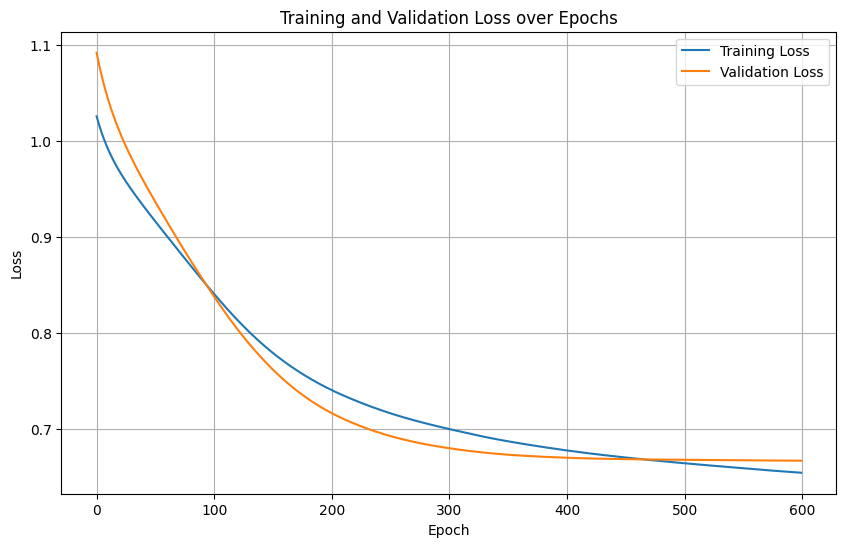

In [ ]:
# Plotting the training and validation losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Check performance characteristics

# Unstandardize predictions and true labels
# mu_Y and sigma_Y are from the standardization step (cell dme5mQqoP4Kh)
val_Y_pred_unscaled = (model_nn(val_X).squeeze() * sigma_Y) + mu_Y

# Convert to binary classes using a threshold (e.g., 0.5)
predicted_classes = (val_Y_pred_unscaled > 0.5).long()

# Get the original true labels for validation set (unstandardized, binary)
true_classes = val_Y_raw.long()

# Convert to numpy arrays, detaching from computation graph
predicted_classes_np = predicted_classes.detach().numpy()
true_classes_np = true_classes.detach().numpy()

from sklearn import metrics
acc = metrics.accuracy_score(true_classes_np, predicted_classes_np)
pre = metrics.precision_score(true_classes_np, predicted_classes_np)
rec = metrics.recall_score(true_classes_np, predicted_classes_np)
F1 = metrics.f1_score(true_classes_np, predicted_classes_np)

print(f"Accuracy:  {acc:.3f}")
print(f"Precision:  {pre:.3f}")
print(f"Recall:  {rec:.3f}")
print(f"F1 Score:  {F1:.3f}")

Accuracy:  0.810
Precision:  0.818
Recall:  0.632
F1 Score:  0.713
